### **1.0) Bibliotecas Necessárias**

In [1244]:
#######################################################################
# Bibliotecas Principais
#######################################################################
import datetime
import pandas as pd
import numpy as np
import session_info
from datetime import datetime 

import warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)

#######################################################################
# Documentação e Alertas
#######################################################################
import tqdm

#######################################################################
# Visualização 
#######################################################################
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from statsmodels.tsa.seasonal import seasonal_decompose

#######################################################################
# Bibliotecas de Machine Learning
#######################################################################
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


### **2.0) Relatório do Ambiente** ###  

In [1245]:
session_info.show (html=False)


-----
matplotlib          3.8.4
numpy               1.26.4
pandas              2.2.1
prophet             1.1.1
seaborn             0.13.2
session_info        1.0.0
sklearn             1.4.2
statsmodels         0.14.2
tabulate            0.9.0
tqdm                4.66.2
xgboost             2.0.3
-----
IPython             8.23.0
jupyter_client      8.6.1
jupyter_core        5.7.2
-----
Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Linux-6.5.0-28-generic-x86_64-with-glibc2.35
-----
Session information updated at 2024-05-01 20:21


### **3.0) Definições Globais**

In [1246]:
Arquivo = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv"


In [1247]:


# create a list of dictionary with student 
# id as key and name as value
# TabelaResultado = {
#                         "Modelo" : [], 
#                         "MAE"    : [], 
#                         "RMSE"   : [],
#                         "MAPE"   : [],
#                         "SMAPE"  : [],
#                         "MDAPE"  : [],
#                         "GMRAE"  : []
#                   }
 
# TabelaResultado ["Modelo"].append ("Tipo1") 
# TabelaResultado ["MAE"].append (1) 
# TabelaResultado ["RMSE"].append (1) 
# TabelaResultado ["MAPE"].append (1) 
# TabelaResultado ["SMAPE"].append (1) 
# TabelaResultado ["MDAPE"].append (1) 
# TabelaResultado ["GMRAE"].append (1) 

# TabelaResultado ["Modelo"].append ("Tipo2") 
# TabelaResultado ["MAE"].append (2) 
# TabelaResultado ["RMSE"].append (2) 
# TabelaResultado ["MAPE"].append (2) 
# TabelaResultado ["SMAPE"].append (2) 
# TabelaResultado ["MDAPE"].append (2) 
# TabelaResultado ["GMRAE"].append (2) 

# dfTemp = pd.DataFrame(TabelaResultado, columns=["Modelo", "MAE", "RMSE", "MAPE", "SMAPE", "MDAPE", "GMRAE"  ])  
# print(tabulate(dfTemp, headers = 'keys', showindex=False, tablefmt = 'psql', numalign="left")) 

### **4.0) Definição das Classes e Objetos**

#### **4.1) Definição da Classes de Dados**

In [1248]:
########################################################################
# Módulo de Dados
########################################################################

class   Dados:    
        LinhasBase = None
        ColunasBase = None       

        DadosDiarios = None    
        DadosTreino = None
        DadosTeste = None        
        
        DadosPredicao = None
        ModeloPredicao = None
        DadosPredicaoXGB = None
        ModeloPredicaoXGB = None        

        XTreino = None
        XTeste = None 
        yTreino = None 
        yTeste = None

        MAEValor = None
        RMSEValor = None
        MAPEValor = None
        SMAPEValor = None
        MDAPEValor = None
        GMRAEValor = None



#### **4.2) Definição da Classe de Informação de Dados**

In [1249]:
########################################################################
# Módulo de Informação de Dados
########################################################################

class   Informacao:             
        def ListaResultado ( self, TabelaResultado):
            dfTemp = pd.DataFrame(TabelaResultado, columns=["Modelo", "MAE", "RMSE", "MAPE", "SMAPE", "MDAPE", "GMRAE"  ])  
            print(tabulate(dfTemp, headers = 'keys', showindex=False, tablefmt = 'psql', numalign="left"))   
            
        def ListaTipos (self ):
            TipoComponente = self.DadosDiarios.dtypes
            NomeComponentes = self.DadosDiarios.columns
            NumeroLinhas, NumeroColunas = self.DadosDiarios.shape
            

            lstParametros = { 
                            "Nome Componente": [], 
                            "Formato Dados" : []            
                            }

            print("#" * 72)
            print('# Conjunto de Dados com {} Linhas e {} Colunas'.format(NumeroLinhas,NumeroColunas))
            print("#" * 72)
            print()            

            for Nome, Tipo in zip(NomeComponentes,TipoComponente[NomeComponentes]):
                lstParametros ["Nome Componente"].append (Nome)
                lstParametros ["Formato Dados"].append (Tipo)  

            dfTemp = pd.DataFrame(lstParametros, columns=["Nome Componente", "Formato Dados" ])        
            print(tabulate(dfTemp, headers = 'keys', showindex=False, tablefmt = 'psql', numalign="left")) 

        def ListaDados (self, NumRegistros):
            lstParametros = { 
                                "Ano": [],
                                "Mes": [],                                
                                "Vendas": []  
                            }

            print("#" * 72)
            print('# Lista de {} Registros'.format(NumRegistros))
            print("#" * 72)
            print()            

            for iAux in range (0,NumRegistros ):
                lstParametros ["Ano"].append (self.DadosDiarios["Ano"][iAux])        
                lstParametros ["Mes"].append (self.DadosDiarios["Mes"][iAux])                            
                lstParametros ["Vendas"].append (self.DadosDiarios["Vendas"][iAux])

            dfTemp = pd.DataFrame(lstParametros, columns=["Ano", "Mes", "Vendas"])        
            print(tabulate(dfTemp, headers = 'keys', showindex=False, tablefmt = 'psql', numalign="left")) 


#### **4.3) Definição da Classe de Cálculo**

In [1250]:
########################################################################
# Módulo de Cálculo dos Dados
########################################################################

class   Calculo:    
        def CriaModeloPredicao ( self, Modelo=1 ):
            if ( Modelo == 1 ):
                self.ModeloPredicao = Prophet()
                self.ModeloPredicao.fit(self.DadosTreino)
            else:
                self.ModeloPredicaoXGB = xgb.XGBRegressor(random_state=1965)
                self.ModeloPredicaoXGB.fit(self.XTreino, self.yTreino)       

        def CalculaPredicao ( self, Modelo=1 ):
            if ( Modelo == 1):
                self.DadosPredicao = self.ModeloPredicao.predict(self.DadosTeste)    
            else:
                self.DadosPredicao = self.ModeloPredicaoXGB.predict(self.DadosTeste) 
     
        def CalculaMAE ( self, Modelo=1 ):
            if ( Modelo == 1):        
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao['yhat'].values
            else:
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao   

            self.MAEValor = mean_absolute_error(yVerdadeiros, yPreditos)
            return ( self.MAEValor )
        
        def CalculaRMSE ( self, Modelo=1 ):
            if ( Modelo == 1):            
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao['yhat'].values
            else:
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao   
                             
            self.RMSEValor = mean_squared_error(yVerdadeiros, yPreditos, squared=False)
            return ( self.RMSEValor )   

        def CalculaMAPE ( self, Modelo=1 ):
            if ( Modelo == 1):            
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao['yhat'].values  
            else:
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao   

            self.MAPEValor = np.mean(np.abs((yVerdadeiros - yPreditos) / yVerdadeiros)) * 100
            return ( self.MAPEValor )  
        
        def CalculaSMAPE ( self, Modelo=1 ):
            if ( Modelo == 1):            
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao['yhat'].values  
            else:
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao   

            self.SMAPEValor = mape = np.mean((np.abs(yVerdadeiros - yPreditos) /((np.abs(yVerdadeiros) +  np.abs(yPreditos)) / 2))) * 100
            return ( self.SMAPEValor )    

        def CalculaMDAPE ( self, Modelo=1 ):
            if ( Modelo == 1):            
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao['yhat'].values  
            else:
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao   

            self.MDAPEValor = np.median(np.abs((yVerdadeiros - yPreditos)/ yVerdadeiros))*100
            return ( self.MDAPEValor )           

        def CalculaGMRAE ( self, Modelo=1 ):
            if ( Modelo == 1):            
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao['yhat'].values      
            else:
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                yVerdadeiros = dfTemp['Vendas'][-12:].values
                yPreditos = self.DadosPredicao   

            self.GMRAEValor = np.prod(np.abs((yVerdadeiros - yPreditos)/ yVerdadeiros) ** (1/len(yVerdadeiros)))*100
            return ( self.GMRAEValor )     
               

#### **4.4) Definição da Classe de Operação de Dados**

In [1251]:
########################################################################
# Módulo de Operação de Dados
########################################################################

class   Operacao:   
        def GravaDados (self, dadosObjeto, strCaminho):
            try:
                dfObjeto = dadosObjeto.copy()
                dfObjeto.to_csv(strCaminho)

            except  Exception as MsgErro:
                    print ( "Processo de Gravação com Erro: ", MsgErro)
                    return              

        def LeituraDados (self, strCaminho):       
            try:
                self.DadosDiarios = pd.read_csv ( strCaminho )
                self.DadosDiarios['Month']= pd.to_datetime(self.DadosDiarios['Month'])                
                self.DadosDiarios [ "Mes" ] = self.DadosDiarios['Month'].dt.month
                self.DadosDiarios [ "Ano" ] = self.DadosDiarios['Month'].dt.year
                self.DadosDiarios = self.DadosDiarios.rename(columns={'Sales': 'Vendas'})                
                self.DadosDiarios.drop('Month', axis=1, inplace=True)
                self.DadosDiarios = self.DadosDiarios.reindex(columns=['Ano',"Mes","Vendas"])
                self.DadosBase = self.DadosDiarios.copy()

            except Exception as MsgErro:
                   print ( "Processo de Leitura com Erro: ", MsgErro)
                   return   
        
        def SeparaDadosTreinoTeste (self, Modelo=1 ):
            if ( Modelo == 1):
               self.DadosTreino = self.DadosDiarios.copy()
               self.DadosTreino['ds'] = pd.to_datetime(self.DadosTreino['Ano'].astype(str)  + self.DadosTreino['Mes'].astype(str), format='%Y%m')
               self.DadosTreino['ds'] = self.DadosTreino['ds'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
               self.DadosTreino.drop(['Mes', "Ano"], axis=1, inplace=True)    
               self.DadosTreino = self.DadosTreino.rename(columns={'Vendas': 'y'})
               self.DadosTreino = self.DadosTreino.reindex(columns=['ds',"y"])         

               self.DadosTeste = self.DadosTreino.drop(self.DadosTreino.index[:-12])
               self.DadosTreino = self.DadosTreino.drop(self.DadosTreino.index[-12:])            
            else:
               dfTempX = self.DadosBase.copy()
               dfTempX.drop ("Vendas",  axis=1, inplace=True)  
               
               dfTempY = self.DadosBase.copy()
               dfTempY.drop ('Mes', axis=1, inplace=True)  
               dfTempY.drop ('Ano', axis=1, inplace=True)  

               dfTempY.reset_index(  inplace = True, drop = True) 
               dfTempX.reset_index(  inplace = True, drop = True)               

               self.XTreino, self.XTeste, self.yTreino, self.yTeste = train_test_split(dfTempX, dfTempY, test_size=0.2)

               self.DadosTeste = self.DadosDiarios.drop(self.DadosDiarios.index[:-12])
               self.DadosTeste.drop ('Vendas', axis=1, inplace=True)  



#### **4.5) Definição da Classe de Visualização de Dados**

In [1252]:
########################################################################
# Módulo de Vizualização de Dados
########################################################################

class   Vizualizacao:   
        def DecomposicaoSerieTemporal ( self ):
            decomposition = seasonal_decompose( self.DadosDiarios['Sales'], model='additive', period=12)
            fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

            decomposition.observed.plot(ax=axes[0], color='green')
            axes[0].set_ylabel('Observados')

            decomposition.trend.plot(ax=axes[1], color='green')
            axes[1].set_ylabel('Tendencia')

            decomposition.seasonal.plot(ax=axes[2], color='green')
            axes[2].set_ylabel('Sazonalidade')

            decomposition.resid.plot(ax=axes[3], color='green')
            axes[3].set_ylabel('Resíduo')
          
            plt.xlabel('Data')
            plt.suptitle('Decomposição da Série Temporal', fontsize=16)
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()

        def MostraResultado ( self, Modelo = 1 ):
            if ( Modelo == 1):
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                x_true = dfTemp['Data'][-12:].values
                y_true = self.DadosTreino['y'][-12:].values

                x_pred = dfTemp['Data'][-12:].values
                y_pred = self.DadosPredicao["yhat"] 

                plt.figure (figsize=(10, 5))
                plt.ylim(10000, 30000)
                plt.plot(x_true, y_true, label='Verdadeiro', marker='o')
                plt.plot(x_pred, y_pred, label='Predito', marker='o')

                plt.title ( "Comportamento da Predição (Prophet)", fontweight="bold", fontsize = 12)
                plt.xlabel ( "Meses", fontweight="bold", fontsize = 10)
                plt.ylabel ( "Volume de Vendas (US$)", fontweight="bold", fontsize = 10)
                plt.legend(bbox_to_anchor=(-0.01,-0.3), loc="lower left", ncol = 2)
                plt.show()
            else:
                dfTemp = self.DadosBase.copy()
                dfTemp['Data'] = pd.to_datetime(dict(year=self.DadosBase['Ano'], month=self.DadosBase['Mes'], day=1))
                x_true = dfTemp['Data'][-12:].values
                y_true = dfTemp['Vendas'][-12:].values

                x_pred = dfTemp['Data'][-12:].values
                y_pred = self.DadosPredicao      
                         
                plt.figure (figsize=(10, 5))
                plt.ylim(10000, 30000)
                plt.plot(x_true, y_true, label='Verdadeiro', marker='o')
                plt.plot(x_pred, y_pred, label='Predito', marker='o')

                plt.title  ( "Comportamento da Predição (xgb)", fontweight="bold", fontsize = 12)
                plt.xlabel ( "Meses", fontweight="bold", fontsize = 10)
                plt.ylabel ( "Volume de Vendas (US$)", fontweight="bold", fontsize = 10)
                plt.legend ( bbox_to_anchor=(-0.01,-0.3), loc="lower left", ncol = 2)
                plt.show() 

        def LinhaPlot   (       self,
                                Estilo = "darkgrid",                     
                                DadosX = [],
                                DadosY = [],
                                lstEtiqueta = [],
                                Largura = 10, 
                                Altura = 5,     
                                Titulo = "", 
                                LegendaX = "", 
                                LegendaY = "",   
                                NumeroLegenda = 0,                  
                                TamanhoFonte = 10                
                        ):

            plt.figure (figsize=(Largura, Altura))
            sns.set_theme(style=Estilo)

            self.DadosBase['Data'] = pd.to_datetime(self.DadosBase['Ano'].astype(str)  + self.DadosBase['Mes'].astype(str), format='%Y%m')
            self.DadosBase['Data'] = self.DadosBase['Data'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
            self.DadosBase['Data']= pd.to_datetime(self.DadosBase['Data'])  
            #  return ( self.DadosBase)
            
            for iAux in range (0, NumeroLegenda):
                sns.lineplot  (
                                   x = self.DadosBase[DadosX[iAux]],
                                   y = self.DadosBase[DadosY[iAux]],
                                   label = lstEtiqueta[iAux], 
                                   marker='o',
                                   data = self.DadosBase
                               )                           

            self.DadosBase.drop(["Data"], axis=1, inplace=True)   
            plt.title ( Titulo, fontweight="bold", fontsize = TamanhoFonte+2)
            plt.xlabel ( LegendaX, fontweight="bold", fontsize = TamanhoFonte)
            plt.ylabel ( LegendaY, fontweight="bold", fontsize = TamanhoFonte)

            plt.legend(bbox_to_anchor=(-0.01,-0.3), loc="lower left", ncol = NumeroLegenda)
            plt.show()


#### **4.6) Definição do Objeto de Dados**

In [1253]:
########################################################################
# Definição do Objeto
########################################################################

class   AvaliacaoPrecisao (Dados, Informacao, Calculo, Operacao, Vizualizacao):
        def __init__(self):
            pass

        def __del__(self):  
            pass

### **5.0) Definições Globais**

In [1254]:
Arquivo = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv"

TabelaResultado = {
                        "Modelo" : [], 
                        "MAE"    : [], 
                        "RMSE"   : [],
                        "MAPE"   : [],
                        "SMAPE"  : [],
                        "MDAPE"  : [],
                        "GMRAE"  : []
                  }


### **6.0) Preparação da Base de Dados**

#### **6.1) Criação do Objeto**

In [1255]:
objPrecisao = AvaliacaoPrecisao()

#### **6.2) Leitura da Base de Dados**

In [1256]:
objPrecisao.LeituraDados (Arquivo)

#### **6.3) Lista de Tipos da Base de Dados**

In [1257]:
objPrecisao.ListaTipos ( )

########################################################################
# Conjunto de Dados com 108 Linhas e 3 Colunas
########################################################################

+-------------------+-----------------+
| Nome Componente   | Formato Dados   |
|-------------------+-----------------|
| Ano               | int32           |
| Mes               | int32           |
| Vendas            | int64           |
+-------------------+-----------------+


#### **6.4) Lista Registros da Base de Dados**

In [1258]:
objPrecisao.ListaDados ( 10 )

########################################################################
# Lista de 10 Registros
########################################################################

+-------+-------+----------+
| Ano   | Mes   | Vendas   |
|-------+-------+----------|
| 1960  | 1     | 6550     |
| 1960  | 2     | 8728     |
| 1960  | 3     | 12026    |
| 1960  | 4     | 14395    |
| 1960  | 5     | 14587    |
| 1960  | 6     | 13791    |
| 1960  | 7     | 9498     |
| 1960  | 8     | 8251     |
| 1960  | 9     | 7049     |
| 1960  | 10    | 9545     |
+-------+-------+----------+


#### **6.6) Gráfico do Comportamento Diário do Preço**

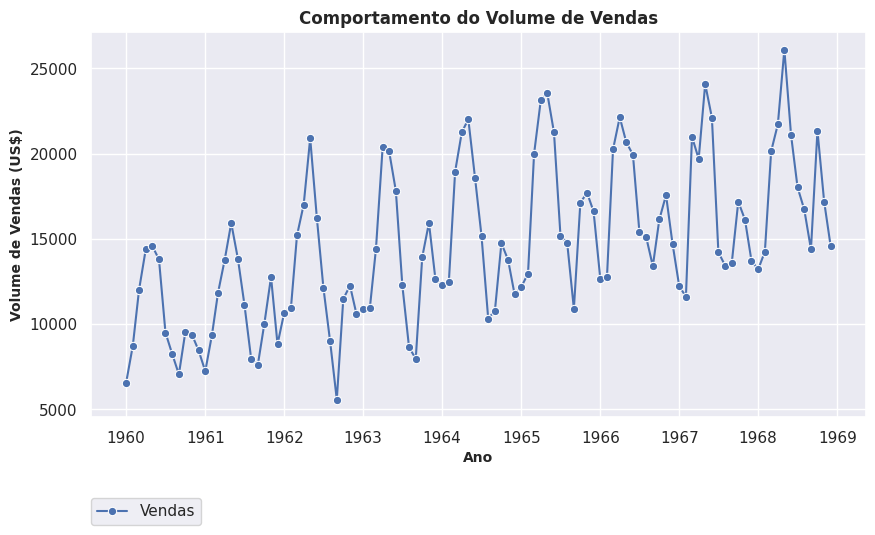

In [1259]:
objPrecisao.LinhaPlot   (
                            LegendaX = "Ano", 
                            Titulo = "Comportamento do Volume de Vendas", 
                            LegendaY = "Volume de Vendas (US$)",
                            DadosX = ["Data" ],
                            DadosY = ["Vendas" ],                
                            NumeroLegenda = 1, 
                            lstEtiqueta = ["Vendas" ]                   
                        )


### **7.0) Procedimentos para Criação, Cálculo e Visualização dos Resultados - Modelo 2**

#### **7.1) Selecionando os Dados para Treino e Teste (Modelo 2)**

In [1260]:
objPrecisao.SeparaDadosTreinoTeste ( Modelo=2 )


#### **7.2) Cria o Modelo de Predição (Modelo 2)**

In [1261]:
objPrecisao.CriaModeloPredicao ( Modelo=2 )

#### **7.3) Calcula a Predição (Modelo 2)**

In [1262]:
objPrecisao.CalculaPredicao ( Modelo=2 )

#### **7.3) Visualização dos Resultados (Modelo 2)**

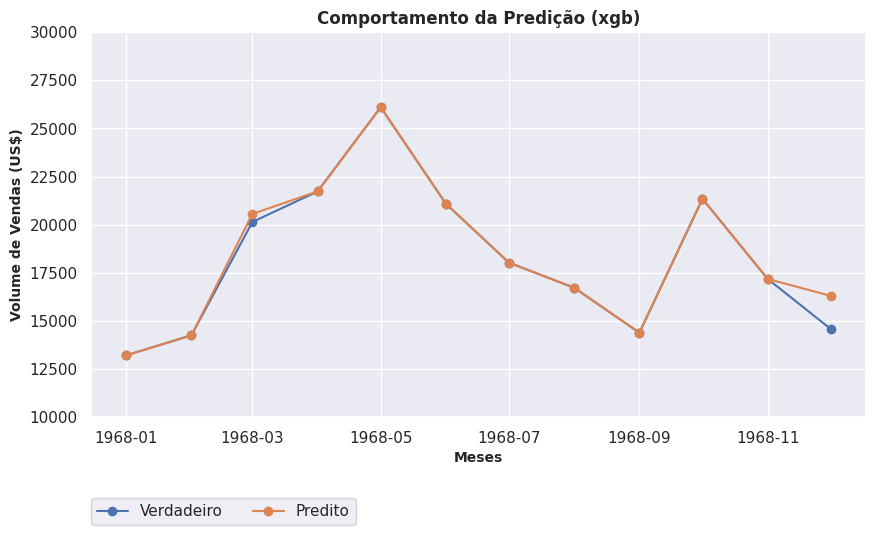

In [1263]:
objPrecisao.MostraResultado ( Modelo=2 )

### **8.0) Calculando as Métricas - Modelo 2**

In [1264]:
TabelaResultado ["Modelo"].append ("XGB") 

#### **8.1) Calculando Mean Absolute Error (MAE)  - Modelo 2**

In [1265]:
MAE = objPrecisao.CalculaMAE ( Modelo=2 )
TabelaResultado ["MAE"].append (MAE) 

#### **8.2) Calculando Root Mean Squared Error (RMSE) - Modelo 2**

In [1266]:
RMSE = objPrecisao.CalculaRMSE ( Modelo=2 )
TabelaResultado ["RMSE"].append (RMSE) 

#### **8.3) Calculando Mean Absolute Percentage Error (MAPE) - Modelo 2**

In [1267]:
MAPE = objPrecisao.CalculaMAPE ( Modelo=2 )
TabelaResultado ["MAPE"].append (MAPE) 

#### **8.4) Calculando Symmetric Mean Absolute Percentage Error (SMAPE) - Modelo 2**

In [1268]:
SMAPE = objPrecisao.CalculaSMAPE ( Modelo=2 )
TabelaResultado ["SMAPE"].append (SMAPE)

#### **8.5) Calculando Median Absolute Percentage Error (MDAPE) - Modelo 2**

In [1269]:
MDAPE = objPrecisao.CalculaMDAPE ( Modelo=2 )
TabelaResultado ["MDAPE"].append (MDAPE) 

#### **8.6) Calculando Geometric Mean Relative Absolute Error (GMRAE) - Modelo 2**

In [1270]:
GMRAE = objPrecisao.CalculaGMRAE ( Modelo=2 )
TabelaResultado ["GMRAE"].append (GMRAE)


### **9.0) Procedimentos para Criação, Cálculo e Visualização dos Resultados - Modelo 1**

#### **9.1) Selecionando os Dados para Treino e Teste (Modelo 1)**

In [1271]:
objPrecisao.SeparaDadosTreinoTeste ( Modelo=1 )

#### **9.2) Cria o Modelo de Predição (Modelo 1)**

In [1272]:
objPrecisao.CriaModeloPredicao ( Modelo=1 )

20:21:35 - cmdstanpy - INFO - Chain [1] start processing


20:21:35 - cmdstanpy - INFO - Chain [1] done processing


#### **9.3) Calcula a Predição (Modelo 1)**

In [1273]:
objPrecisao.CalculaPredicao ( Modelo=1 )

#### **9.4) Visualização dos Resultados (Modelo 1)**

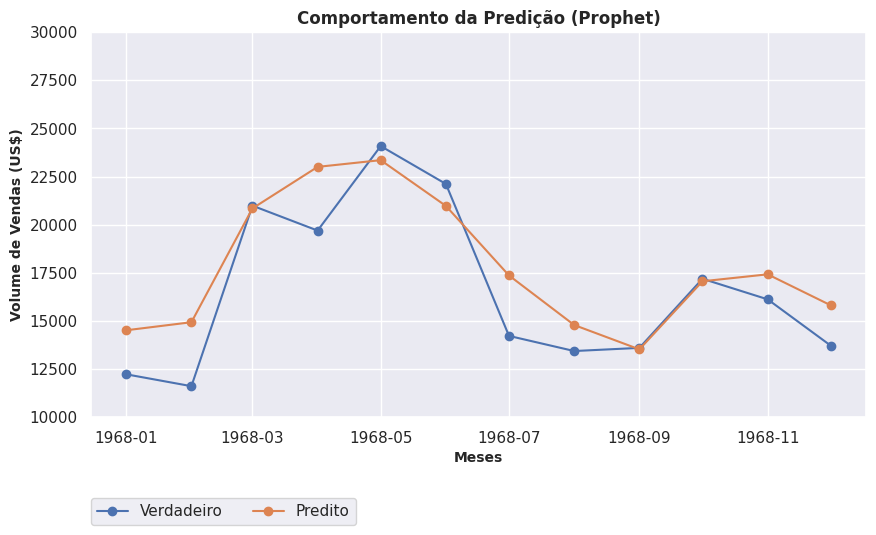

In [1274]:
objPrecisao.MostraResultado ( Modelo=1 )

### **10.0) Calculando as Métricas - Modelo 1**

In [1275]:
TabelaResultado ["Modelo"].append ("Prophet") 

#### **10.1) Calculando Mean Absolute Error (MAE)  - Modelo 1**

In [1276]:
MAE = objPrecisao.CalculaMAE ( Modelo=1 )
TabelaResultado ["MAE"].append (MAE)

#### **10.2) Calculando Root Mean Squared Error (RMSE) - Modelo 1**

In [1277]:
RMSE = objPrecisao.CalculaRMSE ( Modelo=1 )
TabelaResultado ["RMSE"].append (RMSE) 

#### **10.3) Calculando Mean Absolute Percentage Error (MAPE) - Modelo 1**

In [1278]:
MAPE = objPrecisao.CalculaMAPE ( Modelo=1 )
TabelaResultado ["MAPE"].append (MAPE) 

#### **10.4) Calculando Symmetric Mean Absolute Percentage Error (SMAPE) - Modelo 1**

In [1279]:
SMAPE = objPrecisao.CalculaSMAPE ( Modelo=1 )
TabelaResultado ["SMAPE"].append (SMAPE)

#### **10.5) Calculando Median Absolute Percentage Error (MDAPE) - Modelo 1**

In [1280]:
MDAPE = objPrecisao.CalculaMDAPE ( Modelo=1 )
TabelaResultado ["MDAPE"].append (MDAPE)

#### **10.6) Calculando Geometric Mean Relative Absolute Error (GMRAE) - Modelo 1**

In [1281]:
GMRAE = objPrecisao.CalculaGMRAE ( Modelo=1 )
TabelaResultado ["GMRAE"].append (GMRAE)

### **11.0) Tabela de Resultados**

In [1282]:
objPrecisao.ListaResultado ( TabelaResultado)

+----------+---------+---------+---------+---------+------------+----------+
| Modelo   | MAE     | RMSE    | MAPE    | SMAPE   | MDAPE      | GMRAE    |
|----------+---------+---------+---------+---------+------------+----------|
| XGB      | 179.27  | 511.43  | 1.16253 | 1.10587 | 0.00543007 | 0.016791 |
| Prophet  | 1336.81 | 1749.18 | 7.18719 | 7.40709 | 5.9377     | 5.12112  |
+----------+---------+---------+---------+---------+------------+----------+
